This workbook documents the creation of the 2017 CLPX snow depth map (i.e. a dDEM) and the validation process using MagnaProbe snow depth measurements.

In [1]:
# Import Libraries, Set Plotting Options

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import fiona
import seaborn as sns
from rasterio.warp import reproject, Resampling
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from scipy.stats import *
%matplotlib inline
sns.set(color_codes=True)

First I import the most recent CLPX 'snow-free' DEM.
The DEM was moasiced using all June5_2017_CLPX tiles downloaded from the ftp and resampled to 1m x 1m.
The original tiles can be found at: ftp://bering.gps.alaska.edu/pub/chris/snow/

In [2]:
dem_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/bare_earth/clpx_june5_2017_DEM.tif')
dem_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16384,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 397068.0,
       0.0, -1.0, 7624870.0),
 'width': 20480}

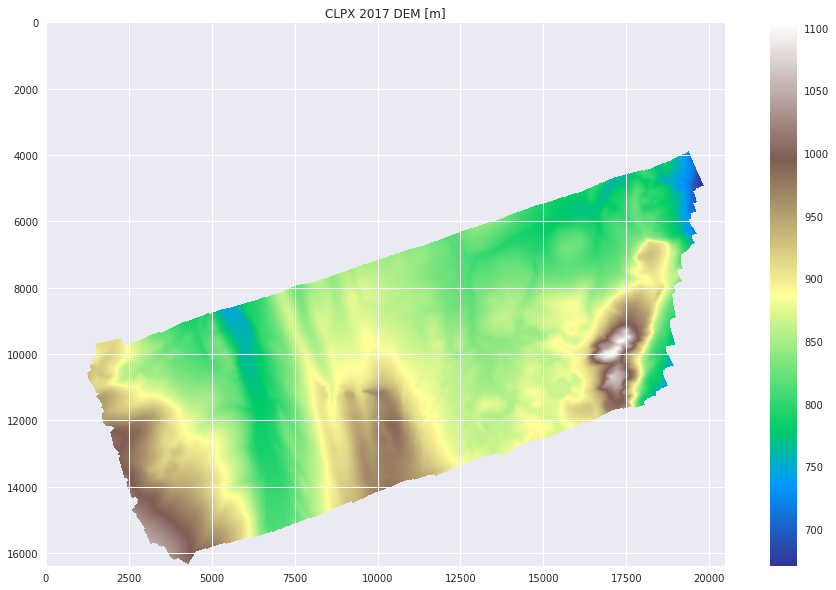

In [3]:
plt.figure(figsize=(16,10))
plt.imshow(dem_src.read(1),cmap='terrain')
plt.title('CLPX 2017 DEM [m]')
plt.colorbar()
plt.show()

The DEM looks good - no holes in the data or really noticeable artifacts. But, the June ortho shows remnant snow drifts. Obviously this will cause values in the snow map to be too low. Drifts won't be as deep as they should be.

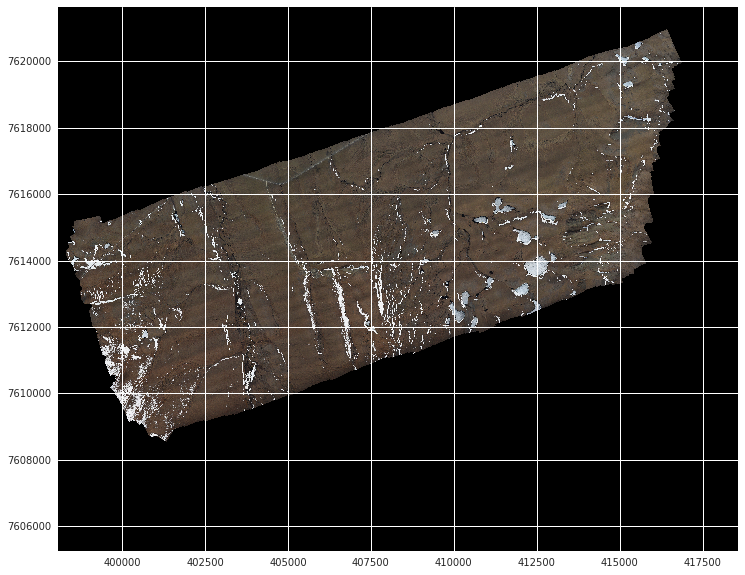

In [4]:
dem_ortho_src = rasterio.open('/home/cparr/surfaces/orthos/clpx/clpx_june5_2017_ortho.tif')
plt.figure(figsize=(16,10))
show(dem_ortho_src)

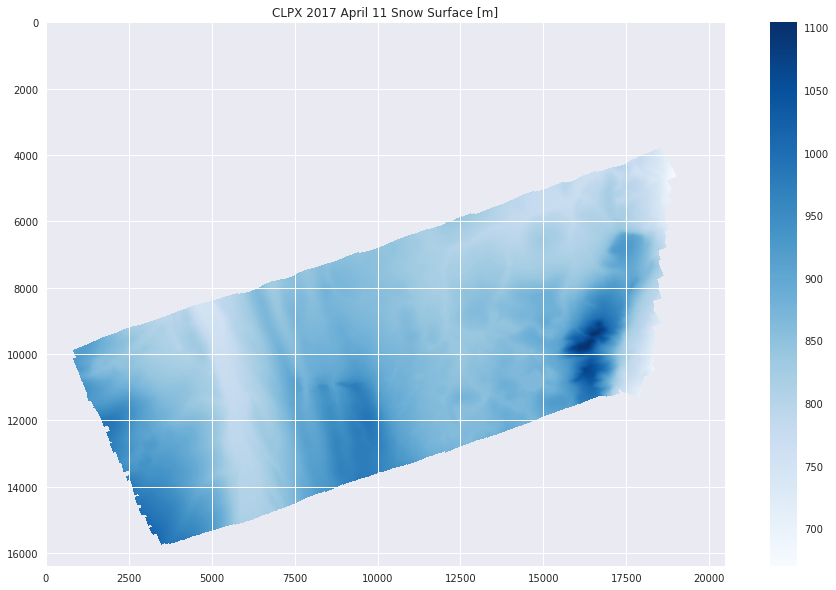

In [5]:
snow_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/clpx_apr11_2017.tif')
plt.figure(figsize=(16,10))
plt.imshow(snow_src.read(1),cmap='Blues')
plt.title('CLPX 2017 April 11 Snow Surface [m]')
plt.colorbar()
plt.show()
out_meta = snow_src.meta.copy() # Copy the metadata for writing out the depth map later

In [6]:
# Before creating the dDEM, I will check for differences in the metadata and print them out.

for k,v in dem_src.meta.items():
    if dem_src.meta[k] != snow_src.meta[k] and k != 'nodata':
        print ('Snow Free DEM: %s = %s, \n Snow ON DEM: %s = %s' % (k,dem_src.meta[k],k,snow_src.meta[k]))

Snow Free DEM: transform = | 1.00, 0.00, 397068.00|
| 0.00,-1.00, 7624870.00|
| 0.00, 0.00, 1.00|, 
 Snow ON DEM: transform = | 1.00, 0.00, 397862.00|
| 0.00,-1.00, 7624653.00|
| 0.00, 0.00, 1.00|


**There is a discrepancy in the metadata.**

What we did in the above cell is loop through the metadata for the snow on and the snow free surfaces.
If there were any differences, we printed them out to the screen. The difference is in the affine
transformation used to describe each surface. Each value in the affine transformation refers to a piece of
information used to translate the array back and forth from geospatial coordinates to array coordinates (rows and columns). Let's see what happens when we create the depth map...

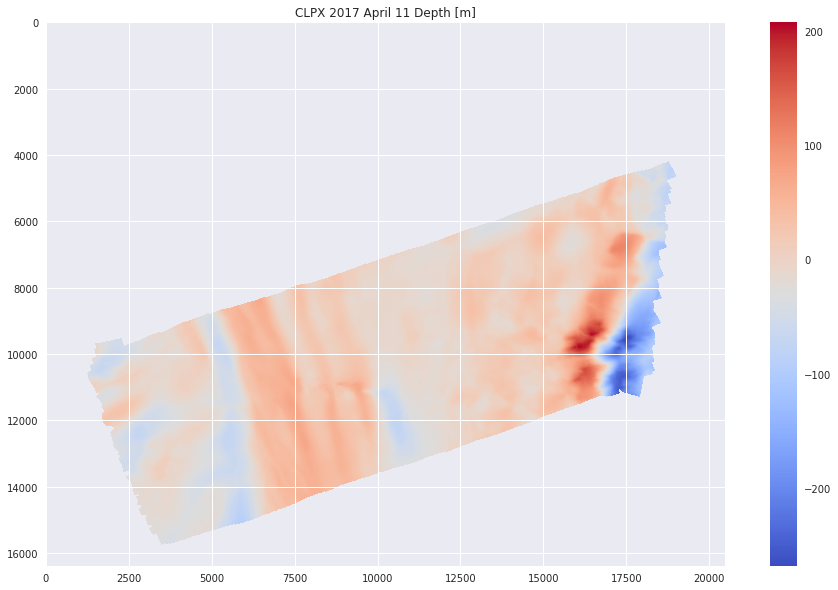

In [7]:
depth = snow_src.read(1) - dem_src.read(1)
depth = depth.astype('float32')

plt.figure(figsize=(16,10))
plt.imshow(depth, cmap='coolwarm')
plt.title('CLPX 2017 April 11 Depth [m]')
plt.colorbar()
plt.show()

Obviously this doesn't look like an accurate result. The scale is way off (-200 to 200) and the pattern basically looks identical to the terrain map. To fix this, we need to transform one of the surfaces to match the others. I will reproject the 'snow on' to match the 'snow free' DEM.

In [8]:
# This code cell applies the transformation and saves the result to a new array.

snow_arr = snow_src.read(1)

# Creating an empty array to store result
new_snow_arr = np.empty(shape=(
                            snow_arr.shape[0],
                            snow_arr.shape[1]))


dem_aff = dem_src.transform

# Using the Snow Free DEM Affine transformation for the new Snow On DEM
new_snow_aff = rasterio.Affine(dem_aff.a, dem_aff.b, dem_aff.c,
                          dem_aff.d, dem_aff.e, dem_aff.f)

reproject(
    snow_arr, new_snow_arr,
    src_transform = snow_src.transform,
    dst_transform = new_snow_aff,
    src_crs = dem_src.crs,
    dst_crs = dem_src.crs,
    resample = Resampling.bilinear)


OK, now that we have applied the transformation, let's create a depth map using the snow array and check the results.

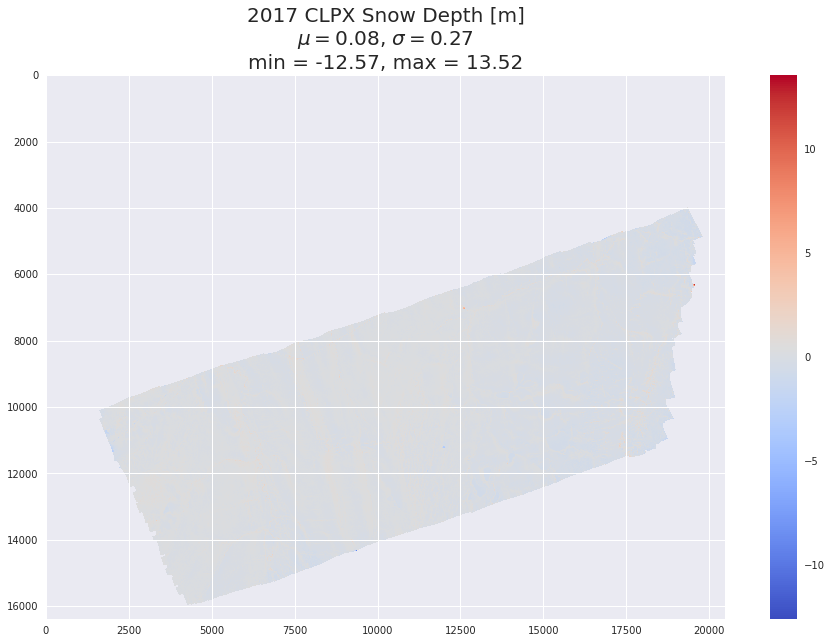

In [9]:
depth = new_snow_arr - dem_src.read(1)
depth = depth.astype('float32')
mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)
im = ax.imshow(depth,vmin=dmin, vmax=dmax, cmap ='coolwarm')
ax.set_title("2017 CLPX Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

The results is better, but the color ramp is still dominated by some extreme values. You can see the bright red dot on the far righ tof the figure. This is an artifact probaly generated when we applied the transformation. Let's clip the surface values to a more reasonable range of snow depths and take a look. The mean value is also way too low. It is likely the whole surface is too low.

/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


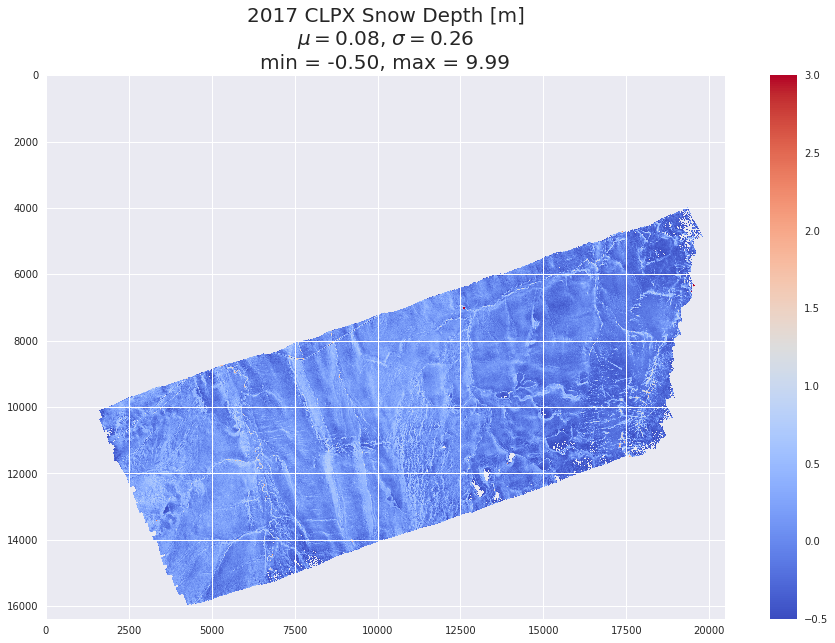

In [10]:
depth[depth < -0.5] = np.nan
depth[depth > 10] = np.nan

mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

im = ax.imshow(depth,vmin=dmin, vmax=3, cmap ='coolwarm')

ax.set_title("2017 CLPX Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

Now we can see some drifts and I think the general pattern is correct but it is clear we need to apply some type of offset. To figure out what this offset should be, we can use the MagnaProbe measurements. Before we explore the offset factor I will put this array back in geospatial coordinates with the proper metadata and write it to disk.

In [11]:
out_meta.update({"transform": new_snow_aff})
with rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_2017_dDEM_no_offset.tif",
                   "w", **out_meta) as dest:
    dest.write(depth,1)

In [12]:
ddem_src = rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_2017_dDEM_no_offset.tif")

In [13]:
# This code block reads in the MagnaProbe shapefile and then compares the depth of the dDEM and the probe 
# measuremnt at each probe location.

with fiona.open("imnav_2017.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
errors = []
sfm = []
probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth'] / 100.0 # Probe Depths come in cm
    probe_sfm_diff = probe_depth - sfm_depth
    errors.append(probe_sfm_diff)
    sfm.append(sfm_depth)
    probe.append(probe_depth)
    
sfm = np.array(sfm)
probe = np.array(probe)
errors = np.array(errors)

For each MagnaProbe measurement I subtracted the dDEM measurment at the same location. Let's take a look at how the two measurement types compare.

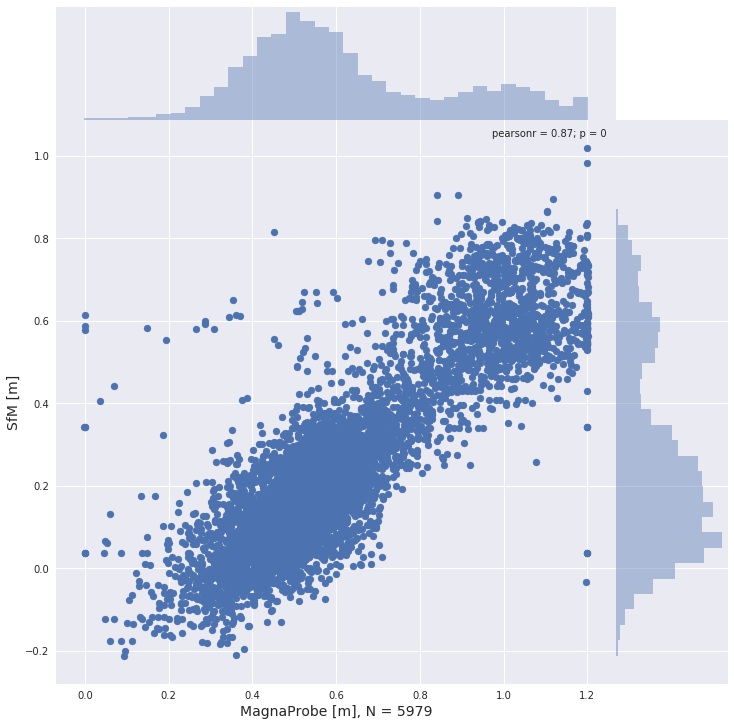

In [14]:
ax = (sns.jointplot(x=probe, y=sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(probe.size), "SfM [m]", fontsize=14))
ax.savefig('/home/cparr/Snow_Patterns/figures/clpx_2017_validation.png', dpi=300)

The two samples correlate pretty well and the distributions look similar. Let's check the errors.

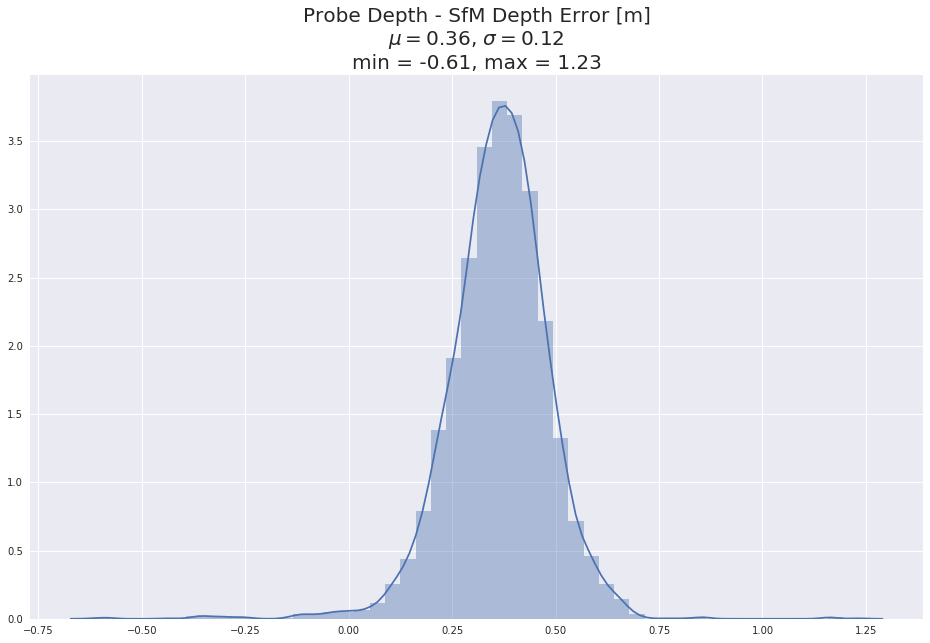

In [15]:
mu = np.nanmean(errors)
sigma = np.nanstd(errors)
dmin = np.nanmin(errors)
dmax = np.nanmax(errors)

plt.figure(figsize=(16,10))
ax = sns.distplot(errors, hist=True)
ax.set_title('Probe Depth - SfM Depth Error [m]' +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax), fontsize=20)

Our dDEM is too low by a mean value of 0.36 m. Let's see what happens when this offset is applied globally.

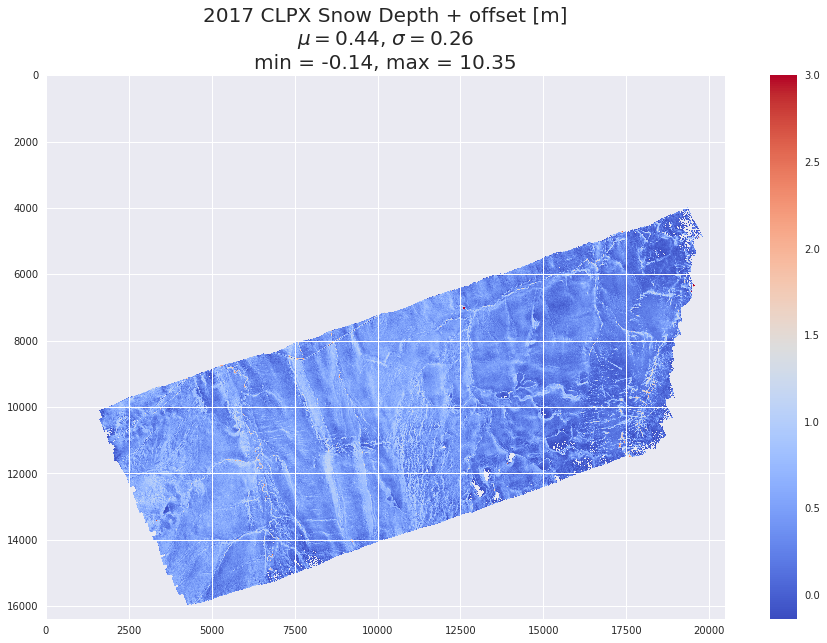

In [16]:
depth = depth + 0.36
mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

im = ax.imshow(depth,vmin=dmin, vmax=3, cmap ='coolwarm')

ax.set_title("2017 CLPX Snow Depth + offset [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

In [17]:
with rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_2017_dDEM_036m_offset.tif",
                   "w", **out_meta) as dest:
    dest.write(depth,1)

In [18]:
clear()

In [19]:
dsrc = rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_2017_dDEM_036m_offset.tif")

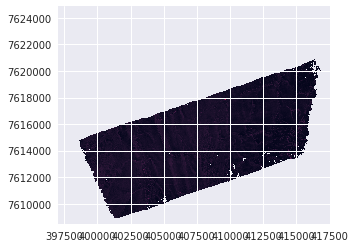

In [20]:
show(dsrc)